In [65]:
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.timeseries import LombScargle

In [5]:
#tic = ['39174351', '118269334', '16046443', '165547989']
tic = '39174351'

search = lk.search_lightcurve(f'TIC {tic}', author='SPOC', exptime=120)
search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 22,2020,SPOC,120,39174351,0.0
1,TESS Sector 49,2022,SPOC,120,39174351,0.0


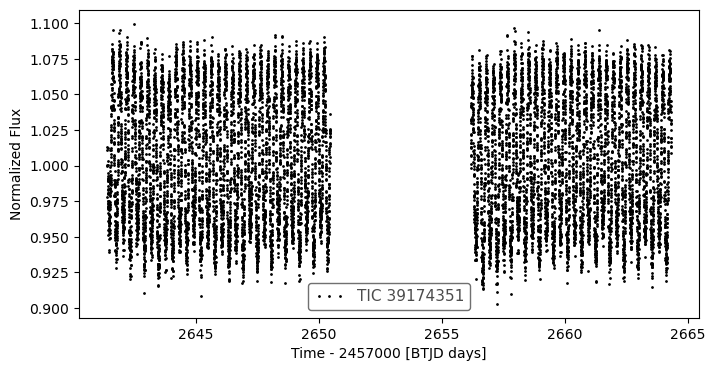

In [6]:
lc = search[1].download().normalize().remove_outliers(sigma=3.5)
#lc = search.download_all().stitch().remove_outliers(sigma=3.5)

fig, ax = plt.subplots(figsize=(8,4))
lc.plot(ax=ax, linewidth=0, marker='o', color='k', markersize=1)
plt.show()

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power'>

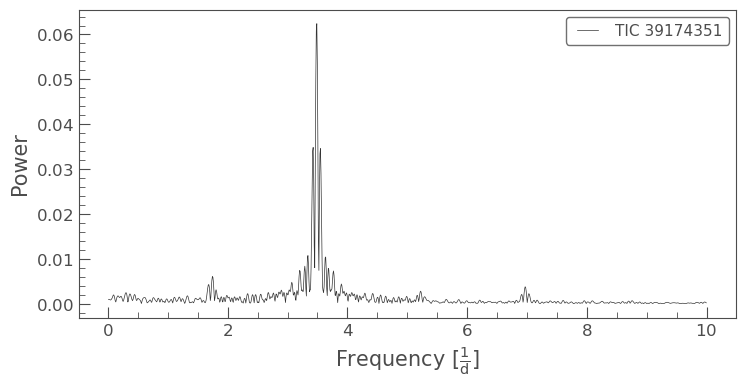

In [7]:
pg = lc.to_periodogram(maximum_frequency=10)
pg.plot()

In [12]:
pg_tab = pg.to_table()
pg_tab

frequency,period,power
1 / d,d,
float64,float64,float64
0.008723115686395291,114.63793854753247,0.0009671667383598692
0.017446231372790583,57.318969273766236,0.0009529439890700212
0.026169347059185874,38.212646182510824,0.0009215983270742628
0.034892462745581165,28.659484636883118,0.0008663258015872485
0.04361557843197646,22.927587709506497,0.0008108914422561846
0.05233869411837175,19.106323091255412,0.0008956971448127583
0.06106180980476704,16.37684836393321,0.0010942154086198404
0.06978492549116233,14.329742318441559,0.0012623221915648338


In [54]:
df_pg_tab = pg_tab.to_pandas()
table = df_pg_tab.filter(['frequency', 'power'])
table

,frequency,power
0,0.008723,0.000967
1,0.017446,0.000953
2,0.026169,0.000922
3,0.034892,0.000866
4,0.043616,0.000811
...,...,...
1141,9.961798,0.000348
1142,9.970521,0.000375
1143,9.979244,0.000342
1144,9.987967,0.000270


In [57]:
main_tab = pd.DataFrame(columns=['frequency', 'power'])

for i in range(5):
    f = float(table.loc[table['power'] == sorted(table.power, reverse=True)[i], 'frequency'])
    p = sorted(table.power, reverse=True)[i]
    new_row = pd.DataFrame(data={'frequency': f, 'power': p}, columns=['frequency', 'power'], index=[i])
    main_tab = pd.concat([main_tab, new_row], axis=0)
    warnings.filterwarnings("ignore")
    
main_tab

C:\Users\jcfis\AppData\Local\Temp\ipykernel_11260\2311574156.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f = float(table.loc[table['power'] == sorted(table.power, reverse=True)[i], 'frequency'])
C:\Users\jcfis\AppData\Local\Temp\ipykernel_11260\2311574156.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f = float(table.loc[table['power'] == sorted(table.power, reverse=True)[i], 'frequency'])
C:\Users\jcfis\AppData\Local\Temp\ipykernel_11260\2311574156.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  f = float(table.loc[table['power'] == sorted(table.power, reverse=True)[i], 'frequency'])
C:\Users\jcfis\AppData\Local\Temp\ipykernel_11260\2311574156.py:4: FutureWarning: Calling floa

,frequency,power
0,3.489246,0.062412
1,3.480523,0.060857
2,3.497969,0.053472
3,3.471800,0.049241
4,3.506693,0.036079


In [59]:
array_table = main_tab.to_numpy()
array_table

array([[3.48924627, 0.06241207],
       [3.48052316, 0.06085699],
       [3.49796939, 0.05347201],
       [3.47180004, 0.04924092],
       [3.50669251, 0.03607919]])

In [96]:
time = lc.time
flux = lc.flux
fap = LombScargle(time, flux).false_alarm_probability(pg.max_power)*100
fap.value

5.951083946484722e-166

In [64]:
final_table = pd.DataFrame(columns=['f0', 'p0', 'f1', 'p1', 'f2', 'p2', 'f3', 'p3', 'f4', 'p4', 'fap'])

temp_tab = pd.DataFrame(data={'f0': array_table[0][0], 'p0':array_table[0][1], 'f1':array_table[1][0], 'p1':array_table[1][1], 'f2':array_table[2][0], 'p2':array_table[2][1], 'f3':array_table[3][0], 'p3':array_table[3][1], 'f4':array_table[4][0], 'p4':array_table[4][1], 'fap':fap.value}, index=[0])

final_table = pd.concat([final_table, temp_tab], axis=0)
final_table

,f0,p0,f1,p1,f2,p2,f3,p3,f4,p4,fap
0,3.489246,0.062412,3.480523,0.060857,3.497969,0.053472,3.4718,0.049241,3.506693,0.036079,5.951084e-166


# New implementation to Lightkurve search

In [70]:
file = pd.read_csv('TIC_List_Test.csv', sep=';')
file

,TIC,Class
0,118269334,Modul
1,50787573,Modul
2,16046443,Noisy
3,165547989,Modul
4,265080539,Modul
5,100013600,Noisy


In [91]:
#tic = '16046443'

for i in range(len(file)):
    search = lk.search_lightcurve(f'TIC {file.iloc[i, 0]}', author='SPOC', exptime=120)
    for j in range(len(search)):
        sector = search.mission[j][12:]
        lc = search[j].download(download_dir='E:/lightkurve_fits/').normalize().remove_outliers(sigma=3.5)
        pg = lc.to_periodogram(maximum_frequency=50)
        
        

['TESS Sector 17' 'TESS Sector 58']
['TESS Sector 06' 'TESS Sector 32']
['TESS Sector 20' 'TESS Sector 47' 'TESS Sector 60']
['TESS Sector 25' 'TESS Sector 26' 'TESS Sector 52']
['TESS Sector 06' 'TESS Sector 33']
['TESS Sector 14' 'TESS Sector 15' 'TESS Sector 21' 'TESS Sector 41'
 'TESS Sector 48' 'TESS Sector 75']


In [92]:
type(search.mission)

numpy.ndarray

In [67]:
search.iloc[:, ]

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance,exptime,obsID,obs_collection_products,dataproduct_type_products,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project_products,prvversion,proposal_id_products,productFilename,size,parent_obsid,dataRights_products,calib_level_products,filters_products,author,mission,#,year,sort_order
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,s,,,,,,,,,,,,,,,,,,,,,,,,
str7,str4,str4,str10,str4,str4,str7,str8,str1,str47,float64,float64,str10,str14,int64,float64,float64,float64,float64,float64,str1,float64,str15,str1,int64,str47,str1,str73,str6,bool,float64,str9,str9,str9,float64,float64,str9,str4,str10,str18,str1,str73,str7,str28,str2,str1,str4,str20,str15,str55,int64,str9,str6,int64,str4,str4,object,int32,int32,int32
science,TESS,SPOC,Photometer,TESS,TESS,Optical,16046443,--,tess2019357164649-s0020-0000000016046443-0165-s,113.356739207438,36.8826936217289,timeseries,"Ricker, George",3,58842.00764455,58868.3272205,120.0,600.0,1000.0,--,58893.0,G022057_G022158,--,20,CIRCLE ICRS 113.35673921 36.88269362 0.00138889,--,mast:TESS/product/tess2019357164649-s0020-0000000016046443-0165-s_lc.fits,PUBLIC,False,nan,27240736,70067763,70067763,0.0,120,27240736,TESS,timeseries,Light curves,S,mast:TESS/product/tess2019357164649-s0020-0000000016046443-0165-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-4.0.27-20200326,G022057_G022158,tess2019357164649-s0020-0000000016046443-0165-s_lc.fits,1926720,27240736,PUBLIC,3,TESS,SPOC,TESS Sector 20,0,2019,1
science,TESS,SPOC,Photometer,TESS,TESS,Optical,16046443,--,tess2021364111932-s0047-0000000016046443-0218-s,113.356739207438,36.8826936217289,timeseries,"Ricker, George",3,59579.321338263886,59606.444756875,120.0,600.0,1000.0,--,59621.0,G04091,--,47,CIRCLE 113.35673921 36.88269362 0.00138889,--,mast:TESS/product/tess2021364111932-s0047-0000000016046443-0218-s_lc.fits,PUBLIC,False,nan,71651454,143588401,143588401,0.0,120,71651454,TESS,timeseries,Light curves,S,mast:TESS/product/tess2021364111932-s0047-0000000016046443-0218-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.58-20220120,G04091,tess2021364111932-s0047-0000000016046443-0218-s_lc.fits,1984320,71651454,PUBLIC,3,TESS,SPOC,TESS Sector 47,1,2021,1
science,TESS,SPOC,Photometer,TESS,TESS,Optical,16046443,--,tess2022357055054-s0060-0000000016046443-0249-s,113.356739207438,36.8826936217289,timeseries,"Ricker, George",3,59936.40708578704,59962.087840416665,120.0,600.0,1000.0,--,59982.0,G05057,--,60,CIRCLE 113.35673921 36.88269362 0.00138889,--,mast:TESS/product/tess2022357055054-s0060-0000000016046443-0249-s_lc.fits,PUBLIC,False,nan,114305556,211953758,211953758,0.0,120,114305556,TESS,timeseries,Light curves,S,mast:TESS/product/tess2022357055054-s0060-0000000016046443-0249-s_lc.fits,SCIENCE,Minimum Recommended Products,LC,--,SPOC,spoc-5.0.79-20221214,G05057,tess2022357055054-s0060-0000000016046443-0249-s_lc.fits,1880640,114305556,PUBLIC,3,TESS,SPOC,TESS Sector 60,2,2022,1
